In [3]:
# import gdown
# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
# import os
# import pyro
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import toolz
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from toolz import groupby, count, reduce, reduceby, countby, identity
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

print(torch.cuda.is_available())

#plt.ion()
#sc.settings.verbosity = 3
#sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [5]:
enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()


@curry
def binarize(x: torch.Tensor, threshold: float = 0.25) -> torch.Tensor:
    ret = (x > threshold).float()
    return ret


transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.FashionMNIST(
    "data/",
    train=True,
    download=True,
    transform=transform,
)
test_dataset = datasets.FashionMNIST(
    "data/",
    train=False,
    download=True,
    transform=transform,
)
train_data = train_dataset.data.float() / 255
test_data = test_dataset.data.float() / 255
train_labels = F.one_hot(
    train_dataset.targets.long(),
    num_classes=10,
).float()
test_labels = F.one_hot(
    test_dataset.targets.long(),
    num_classes=10,
).float()

data_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            train_data,
            train_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            test_data,
            test_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)

#subset = ut.randomSubset(s=len(train_labels), r=0.1)
subset = ut.randomSubset(s=len(train_labels), r=0.111)
labeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(
            data=train_data[subset],
            labels=train_labels[subset],
            ),
        batch_size=128,
        shuffle=True,
        )
unlabeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(
            data=train_data[subset == False],
            labels=train_labels[subset == False],
            ),
        batch_size=128,
        shuffle=True,
        )

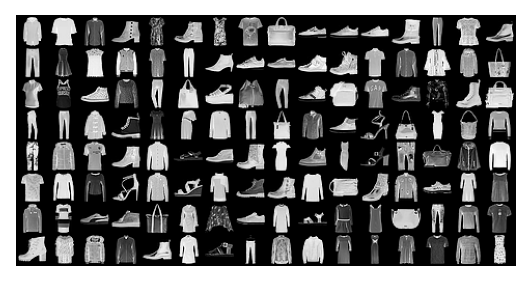

torch.Size([128, 28, 28])

In [6]:
#x,y = test_loader.__iter__().next()
x,y = test_loader.__iter__().__next__()
ut.plot_images(x.reshape(-1,1,28,28),)
x.shape

In [14]:
d = {
    0 : "Tshirt",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Boot",
}

In [11]:
adata = sc.AnnData(X = test_data.flatten(1).detach().numpy())
adata.obs['labels'] = test_labels.argmax(-1).numpy().astype(str)

In [19]:
names = list(test_labels.argmax(-1).numpy())
names = [d[i] for i in names]
names
adata.obs['text_labels'] = names
adata.obs

labels louvain text_labels
0         9       9        Boot
1         2       0    Pullover
2         1       1     Trouser
3         1       1     Trouser
4         6       3       Shirt
...     ...     ...         ...
9995      9       4        Boot
9996      1       1     Trouser
9997      8      11         Bag
9998      1       1     Trouser
9999      5      10      Sandal

[10000 rows x 3 columns]

In [4]:
sc.pp.pca(adata,)
sc.pp.neighbors(adata,)
sc.tl.umap(adata,)
sc.tl.louvain(adata,)

NameError: name 'adata' is not defined

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


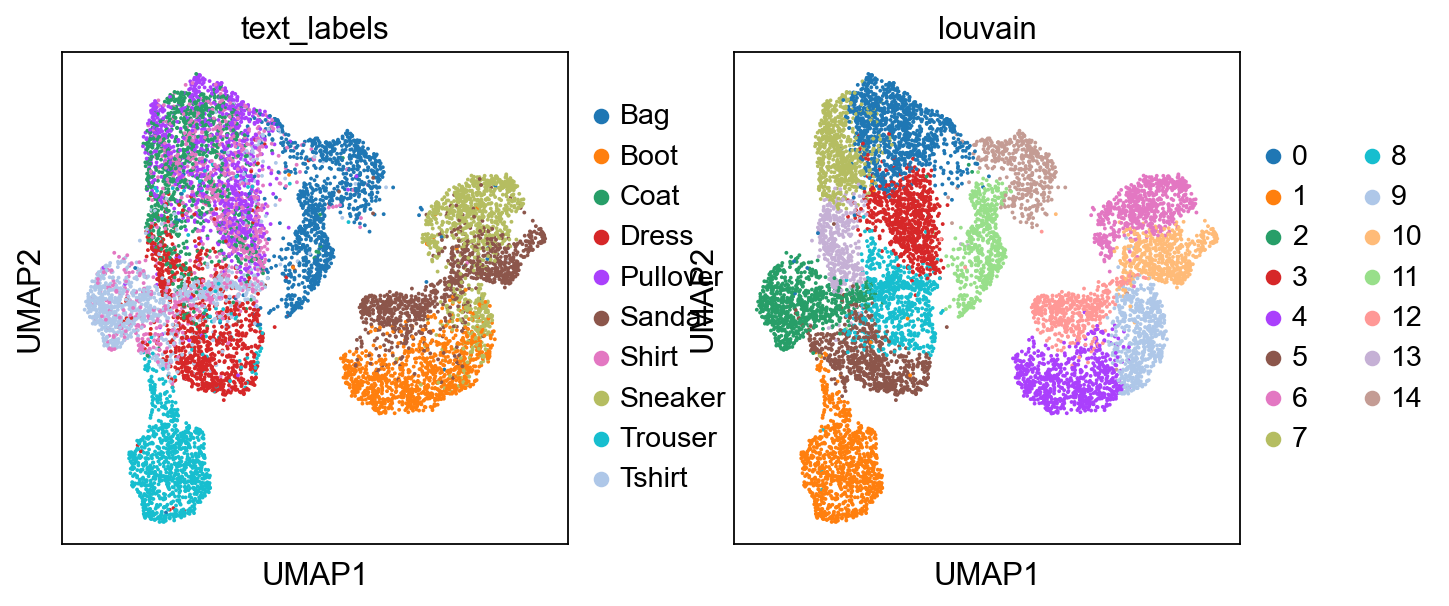

In [20]:
sc.pl.umap(
    adata,
    color=[
        "text_labels",
        #"pred",
        "louvain",
    ],
)

## FashionMNIST Unsupervised

In [6]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602z(
    nx=28**2,
    nclasses=30,
    nh=1024,
    nhq=1024,
    nhp=1024,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=2e-2,
    bn=True,
    reclosstype="Bernoulli",
    #reclosstype="mse",
    #relax=False,
    relax=True,
    restrict_w=True,
    restrict_z=True,
    nz=18,
    nw=18,
)
model.apply(init_weights)
model.__class__

gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602z

epoch's lr =  0.001
epoch 0
training phase
rec: 595.6729125976562
loss_z: 23.423721313476562
loss_w: 10.394641876220703
loss_cluster: -0.18140031397342682
loss_d: 15.697306632995605
loss_y_alt: 1.7619762420654297
loss_y_alt2: 0
total_loss: 646.9505615234375
num_clusters: 1



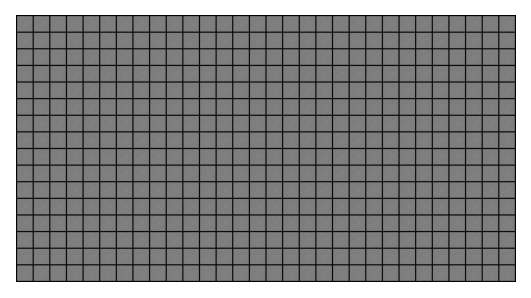

[ 8.  1. -1. -1.  5. -1.  1.  9. -1.  3. -1. -1.  0. -1. -1.  9. -1.  7.
  5.  2. -1. -1.  3.  6.  4. -1. -1. -1. -1. -1.] 
 -0.2987037037037037 
 [ 0.3         0.4        -1.         -1.          0.5        -1.
  0.25        0.26666667 -1.          1.         -1.         -1.
  1.         -1.         -1.          1.         -1.          0.3
  0.3         0.22222222 -1.         -1.          0.16666667  1.
  0.33333333 -1.         -1.         -1.         -1.         -1.        ]
0.45535714285714285 

epoch's lr =  0.001
epoch 0
training phase
rec: 219.17947387695312
loss_z: 10.55502700805664
loss_w: 1.6411296129226685
loss_cluster: -0.9607411623001099
loss_d: 0.6571980714797974
loss_y_alt: 2.8994593620300293
loss_y_alt2: 0
total_loss: 234.93228149414062
num_clusters: 22



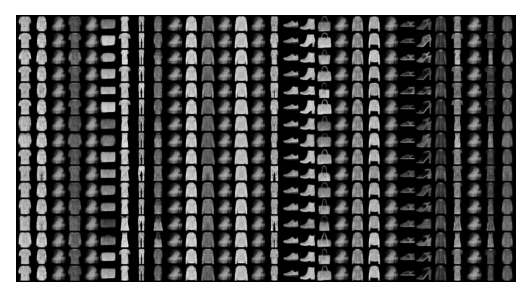

[ 0.  4. -1.  6. -1.  8.  0.  1.  0. -1.  6. -1. -1.  2. -1.  3.  7.  9.
  8. -1.  2.  2. -1.  5.  5.  2.  0. -1.  0.  2.] 
 0.15095238095238098 
 [ 0.5         0.5        -1.          0.6        -1.          0.8
  0.33333333  1.          0.5        -1.          0.5        -1.
 -1.          0.4        -1.          1.          0.83333333  1.
  1.         -1.          0.4         0.5        -1.          1.
  1.          0.5         0.4        -1.          0.42857143  0.33333333]
0.8151260504201681 

epoch's lr =  0.0001
epoch 0
training phase
rec: 222.2377471923828
loss_z: 10.775794982910156
loss_w: 1.7342617511749268
loss_cluster: -0.9449220895767212
loss_d: 0.6383254528045654
loss_y_alt: 2.654179096221924
loss_y_alt2: 0
total_loss: 238.04031372070312
num_clusters: 22



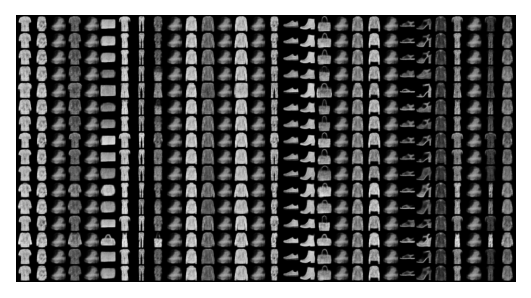

[ 0.  2. -1.  0. -1.  8.  0.  1.  3. -1.  2.  6. -1.  2. -1.  3.  7.  9.
  8. -1.  4.  2. -1.  5.  5.  2.  0. -1.  0.  4.] 
 0.304047619047619 
 [ 0.5         1.         -1.          0.83333333 -1.          1.
  0.57142857  1.          0.66666667 -1.          0.5         0.6
 -1.          0.75       -1.          0.66666667  0.66666667  0.8
  1.         -1.          0.8         0.83333333 -1.          1.
  1.          1.          0.66666667 -1.          0.6         0.66666667]
0.8833333333333333 

epoch's lr =  0.0001
epoch 0
training phase
rec: 217.75511169433594
loss_z: 10.326496124267578
loss_w: 2.0463409423828125
loss_cluster: -0.9597030282020569
loss_d: 0.6718381643295288
loss_y_alt: 2.6238441467285156
loss_y_alt2: 0
total_loss: 233.4236297607422
num_clusters: 20



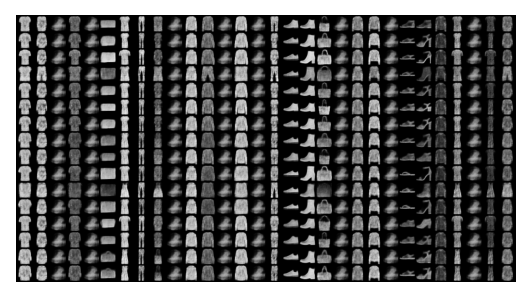

[ 6.  2. -1.  0. -1.  8.  0.  1.  8. -1.  4.  2. -1.  2. -1.  3.  7.  9.
  8. -1.  2.  4. -1.  5.  5.  2.  3. -1.  3. -1.] 
 0.22078532578532575 
 [ 0.66666667  0.5        -1.          1.         -1.          1.
  0.42857143  1.          0.5        -1.          0.66666667  0.66666667
 -1.          1.         -1.          0.83333333  0.76923077  0.9
  1.         -1.          0.5         0.75       -1.          1.
  0.90909091  0.33333333  0.6        -1.          0.6        -1.        ]
0.8991596638655462 

epoch's lr =  1e-05
epoch 0
training phase
rec: 220.73265075683594
loss_z: 10.401159286499023
loss_w: 1.9612927436828613
loss_cluster: -0.9571942687034607
loss_d: 0.6585588455200195
loss_y_alt: 2.75042462348938
loss_y_alt2: 0
total_loss: 236.5040740966797
num_clusters: 22



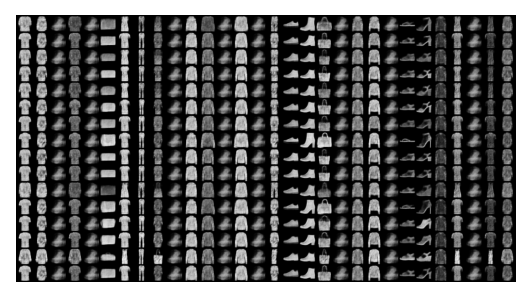

[ 0.  6. -1.  0. -1.  8.  3.  1. -1. -1.  4.  2. -1.  2. -1.  3.  7.  9.
  8. -1.  4.  4. -1.  5.  5.  6.  3. -1.  3.  3.] 
 0.23732804232804233 
 [ 0.83333333  0.75       -1.          0.5        -1.          1.
  0.5         1.         -1.         -1.          0.75        1.
 -1.          0.5        -1.          1.          0.85714286  0.91666667
  1.         -1.          0.6         0.66666667 -1.          0.85714286
  1.          0.66666667  0.55555556 -1.          0.66666667  0.5       ]
0.9495798319327731 

epoch's lr =  1e-05
epoch 0
training phase
rec: 225.51531982421875
loss_z: 10.470708847045898
loss_w: 1.7440276145935059
loss_cluster: -0.9641695618629456
loss_d: 0.6297609806060791
loss_y_alt: 2.645872116088867
loss_y_alt2: 0
total_loss: 241.0056915283203
num_clusters: 22



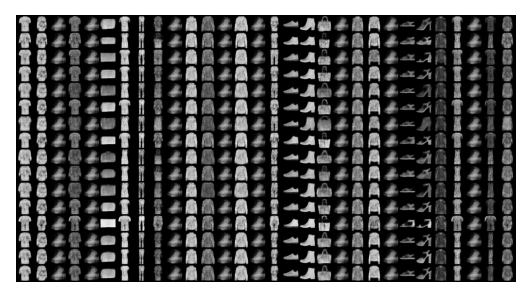

[ 0.  4. -1.  0. -1.  8.  0.  1.  8. -1.  4.  2. -1.  2. -1.  3.  7.  9.
  8. -1.  4.  4. -1.  5.  5.  2.  1. -1.  3.  4.] 
 0.27500841750841754 
 [ 0.6         1.         -1.          0.5        -1.          0.8
  0.55555556  1.          0.5        -1.          0.625       0.66666667
 -1.          0.6        -1.          0.66666667  0.8         1.
  1.         -1.          0.63636364  0.8        -1.          1.
  1.          0.66666667  0.33333333 -1.          1.          0.5       ]
0.8666666666666667 

epoch's lr =  1e-06
epoch 0
training phase
rec: 209.81787109375
loss_z: 10.320517539978027
loss_w: 1.885563850402832
loss_cluster: -0.97765052318573
loss_d: 0.69283527135849
loss_y_alt: 2.7203617095947266
loss_y_alt2: 0
total_loss: 225.43714904785156
num_clusters: 22



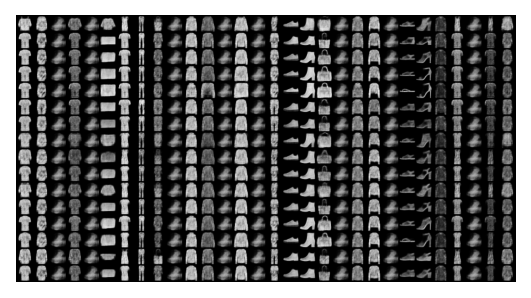

[ 6.  2. -1. -1. -1.  8.  0.  1.  3. -1.  4.  2. -1.  2. -1.  1.  7.  9.
  8. -1.  2.  4. -1.  5.  5.  2.  3. -1.  0.  2.] 
 0.18400793650793648 
 [ 0.66666667  0.33333333 -1.         -1.         -1.          1.
  0.7         1.          0.4        -1.          0.85714286  0.33333333
 -1.          0.5        -1.          0.5         0.875       1.
  1.         -1.          0.57142857  0.75       -1.          1.
  1.          0.33333333  0.8        -1.          0.4         0.5       ]
0.9243697478991597 

epoch's lr =  1e-06
epoch 0
training phase
rec: 219.43528747558594
loss_z: 9.987041473388672
loss_w: 1.8632142543792725
loss_cluster: -0.9599738121032715
loss_d: 0.6706341505050659
loss_y_alt: 2.7396528720855713
loss_y_alt2: 0
total_loss: 234.6958465576172
num_clusters: 22



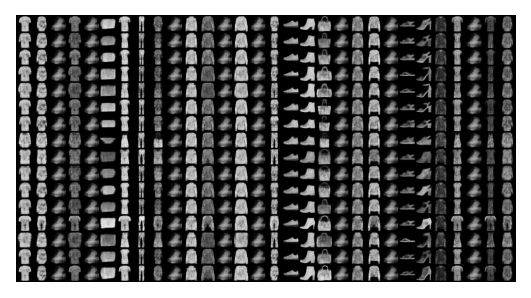

[ 6.  4. -1.  6. -1.  8.  0.  1.  0. -1.  4. -1. -1.  2. -1.  1.  7.  9.
  8. -1.  6.  4. -1.  5.  5.  6.  3. -1.  3.  1.] 
 0.21887445887445883 
 [ 0.66666667  1.         -1.          0.66666667 -1.          1.
  0.6         1.          1.         -1.          0.42857143 -1.
 -1.          0.42857143 -1.          0.33333333  0.93333333  1.
  1.         -1.          0.44444444  0.6        -1.          0.90909091
  1.          1.          0.55555556 -1.          0.5         0.5       ]
0.865546218487395 

done training


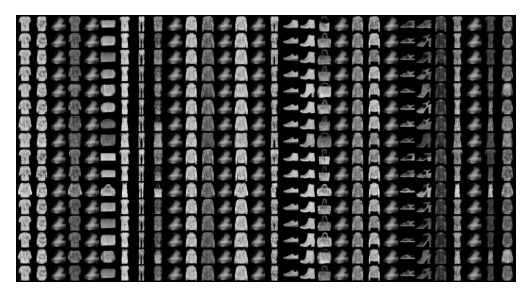

0.6982


<Figure size 320x320 with 0 Axes>

In [7]:
#reload(Train)
Train.basicTrainLoop(
    model,
    data_loader,
    test_loader,
    num_epochs=30,
    #lrs=[1e-3,5e-4,1e-4,5e-5,1e-5],
    lrs = [
        1e-3,
        1e-3,
        1e-4,
        1e-4,
        1e-5,
        1e-5,
        1e-6,
        1e-6,
    ],
    wt=1e-7,
    report_interval=70,
    do_plot=True,
    test_accuracy=True,
)
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

In [8]:
ut.saveModelParameters(
        model,
        "./results/final_gmmvaez_fmnist30_s_part00" + ut.timeStamp() + ut.randomString() + "params.pt",
        method="json",
        )
torch.save(
        model.state_dict(),
        "./results/final_gmmvaez_fmnist30_s_part00" + ut.timeStamp() + ut.randomString() + "state.pt",
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 214.46705627441406
loss_z: 10.248380661010742
loss_w: 2.0252575874328613
loss_cluster: -0.9740782976150513
loss_d: 0.66452956199646
loss_y_alt: 2.771360158920288
loss_y_alt2: 0
total_loss: 230.1765899658203
num_clusters: 22



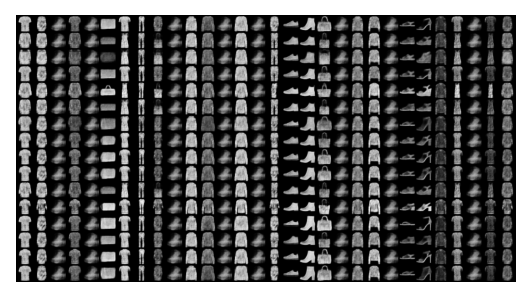

[ 6.  4. -1.  6. -1.  8.  0.  1.  3. -1.  4.  2. -1.  6. -1.  3.  7.  9.
  8. -1.  2.  2. -1.  5.  5.  2.  6. -1.  0. -1.] 
 0.23567460317460315 
 [ 1.          0.66666667 -1.          0.6        -1.          1.
  0.8         1.          1.         -1.          0.375       1.
 -1.          0.33333333 -1.          0.75        0.66666667  0.8
  1.         -1.          0.42857143  1.         -1.          1.
  1.          0.5         0.75       -1.          0.4        -1.        ]
0.8571428571428571 

epoch's lr =  0.001
epoch 0
training phase
rec: 217.11900329589844
loss_z: 10.367286682128906
loss_w: 1.8775053024291992
loss_cluster: -0.9818501472473145
loss_d: 0.7085927128791809
loss_y_alt: 2.749459743499756
loss_y_alt2: 0
total_loss: 232.8218536376953
num_clusters: 22



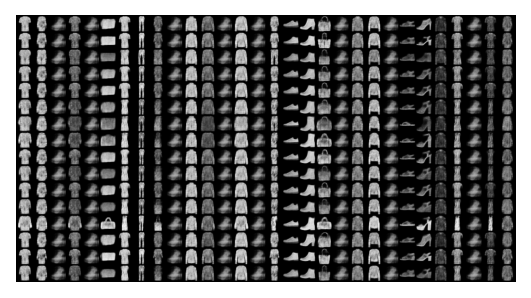

[ 0.  0. -1.  0. -1.  8.  0.  1.  3. -1.  4.  2. -1.  2. -1.  1.  7.  9.
  8. -1.  6.  2. -1.  5.  5.  6.  3. -1.  0.  6.] 
 0.26447089947089947 
 [ 0.66666667  0.5        -1.          0.6        -1.          1.
  0.6         1.          0.5        -1.          0.5         1.
 -1.          0.25       -1.          0.4         0.92857143  1.
  1.         -1.          0.66666667  0.5        -1.          0.77777778
  1.          0.6         0.77777778 -1.          1.          0.66666667]
0.875 

epoch's lr =  0.0001
epoch 0
training phase
rec: 219.99209594726562
loss_z: 10.346681594848633
loss_w: 1.7716820240020752
loss_cluster: -0.972855269908905
loss_d: 0.6768822073936462
loss_y_alt: 2.7731571197509766
loss_y_alt2: 0
total_loss: 235.5605010986328
num_clusters: 22



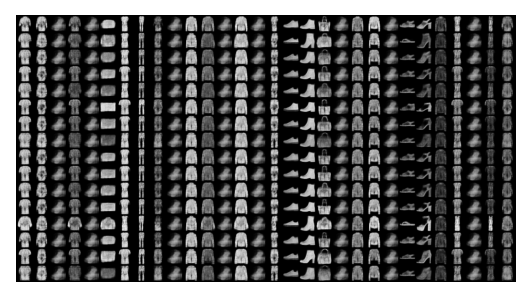

[ 0.  4. -1.  0. -1.  8.  0.  1.  3. -1.  4.  2. -1.  2. -1. -1.  7.  9.
  8. -1.  6.  2. -1.  5.  5.  2.  3. -1.  0.  1.] 
 0.19182539682539682 
 [ 1.          1.         -1.          0.66666667 -1.          1.
  0.33333333  1.          0.5        -1.          0.66666667  0.5
 -1.          0.5        -1.         -1.          0.95        0.9
  1.         -1.          0.57142857  0.5        -1.          1.
  1.          0.33333333  0.5        -1.          0.33333333  0.5       ]
0.907563025210084 

epoch's lr =  0.0001
epoch 0
training phase
rec: 215.0545654296875
loss_z: 10.608016967773438
loss_w: 1.966658115386963
loss_cluster: -0.9636845588684082
loss_d: 0.6450425982475281
loss_y_alt: 2.9332337379455566
loss_y_alt2: 0
total_loss: 231.20751953125
num_clusters: 22



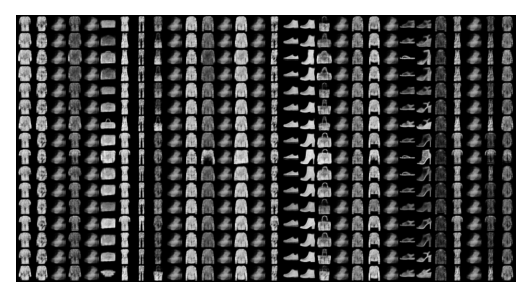

[ 0.  4. -1.  6. -1.  8.  3.  1.  3. -1.  4.  4. -1.  4. -1.  1.  7.  9.
  8. -1.  4.  4. -1.  5.  5.  2.  0. -1.  3.  3.] 
 0.24107843137254903 
 [ 0.6         0.75       -1.          1.         -1.          0.8
  0.4         1.          0.5        -1.          0.8         0.5
 -1.          0.5        -1.          0.33333333  0.83333333  0.88235294
  0.875      -1.          1.          0.5        -1.          1.
  1.          0.66666667  0.33333333 -1.          0.625       0.33333333]
0.825 

epoch's lr =  1e-05
epoch 0
training phase
rec: 220.8303985595703
loss_z: 10.604366302490234
loss_w: 1.9879651069641113
loss_cluster: -0.9586066007614136
loss_d: 0.6364858746528625
loss_y_alt: 2.866727828979492
loss_y_alt2: 0
total_loss: 236.9259490966797
num_clusters: 22



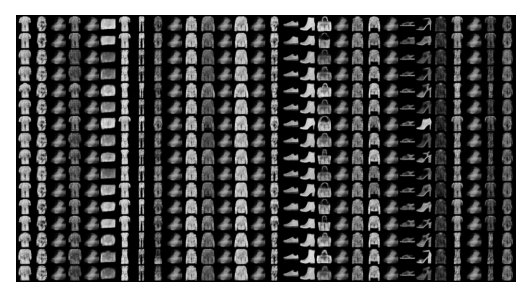

[ 0.  0. -1.  0. -1.  8.  0.  1.  3. -1.  4.  2. -1.  2. -1.  1.  7.  9.
  8. -1.  2.  2. -1.  5.  5.  2.  3. -1.  3.  4.] 
 0.23060606060606056 
 [ 0.75        0.4        -1.          0.66666667 -1.          1.
  0.6         1.          0.4        -1.          0.57142857  0.66666667
 -1.          0.5        -1.          0.33333333  1.          0.81818182
  1.         -1.          0.42857143  0.4        -1.          1.
  0.7         1.          0.6        -1.          0.75        0.33333333]
0.8166666666666667 

epoch's lr =  1e-05
epoch 0
training phase
rec: 211.96156311035156
loss_z: 10.16771125793457
loss_w: 2.079341173171997
loss_cluster: -0.9608059525489807
loss_d: 0.6388079524040222
loss_y_alt: 2.6870219707489014
loss_y_alt2: 0
total_loss: 227.53445434570312
num_clusters: 21



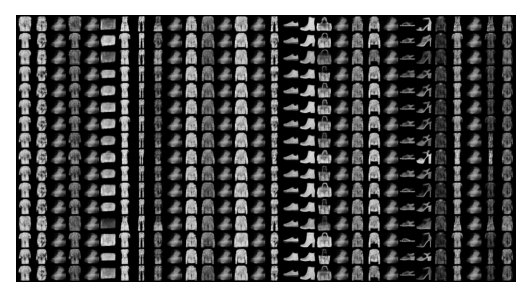

[ 0.  4. -1.  2. -1.  8.  0.  1.  4. -1.  4.  1. -1.  6. -1.  3.  7.  9.
  8. -1.  6.  2. -1.  5.  5.  6.  3. -1.  0. -1.] 
 0.17755991285403047 
 [ 0.75        0.66666667 -1.          1.         -1.          0.66666667
  0.44444444  1.          0.4        -1.          0.4         1.
 -1.          0.5        -1.          0.5         0.91666667  0.88235294
  1.         -1.          0.4         0.6        -1.          1.
  0.5         0.6         0.5        -1.          0.6        -1.        ]
0.8319327731092437 

epoch's lr =  1e-06
epoch 0
training phase
rec: 212.01614379882812
loss_z: 10.489181518554688
loss_w: 1.9671586751937866
loss_cluster: -0.9700924158096313
loss_d: 0.6625989079475403
loss_y_alt: 2.6586191654205322
loss_y_alt2: 0
total_loss: 227.793701171875
num_clusters: 21



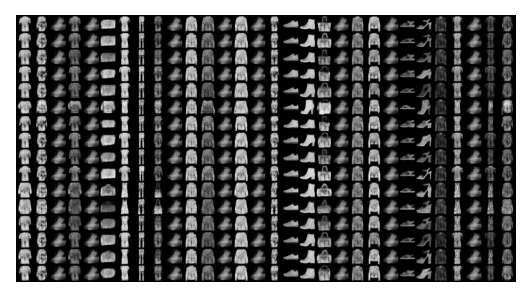

[ 0. -1. -1.  6. -1.  8.  0.  1.  8. -1.  4.  2. -1.  2. -1.  3.  7.  9.
  8. -1.  2.  2. -1.  5.  5.  6.  0. -1.  3.  6.] 
 0.2271103896103896 
 [ 0.57142857 -1.         -1.          1.         -1.          1.
  0.5         1.          1.         -1.          0.5         0.54545455
 -1.          0.75       -1.          0.71428571  0.65        0.85714286
  1.         -1.          0.5         0.66666667 -1.          0.875
  1.          0.6         0.33333333 -1.          0.75        1.        ]
0.865546218487395 

epoch's lr =  1e-06
epoch 0
training phase
rec: 219.65994262695312
loss_z: 10.312471389770508
loss_w: 1.916142225265503
loss_cluster: -0.952886164188385
loss_d: 0.6475332379341125
loss_y_alt: 2.7558789253234863
loss_y_alt2: 0
total_loss: 235.29196166992188
num_clusters: 22



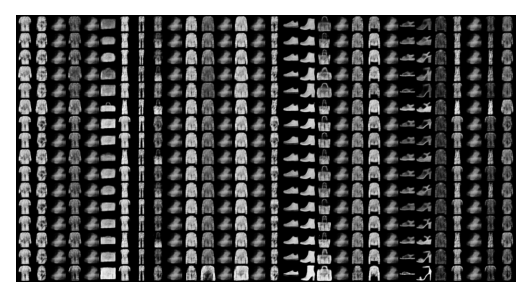

[ 0.  4. -1.  0. -1.  8.  3.  1.  3. -1.  4.  2. -1.  2. -1.  3.  7.  9.
  8. -1.  2.  2. -1.  5.  5.  2.  0. -1.  3.  4.] 
 0.2851388888888889 
 [ 0.75        0.75       -1.          0.66666667 -1.          0.85714286
  0.42857143  1.          0.42857143 -1.          0.57142857  0.8
 -1.          0.5        -1.          0.71428571  0.9375      1.
  1.         -1.          0.4         1.         -1.          1.
  1.          0.5         1.         -1.          0.75        0.5       ]
0.875 

done training


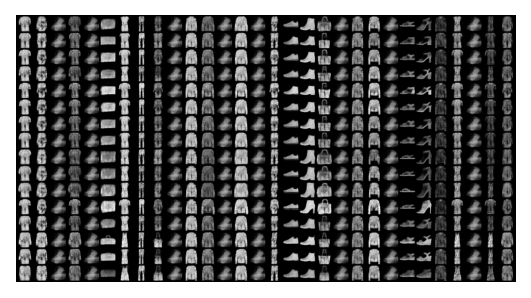

0.6978


<Figure size 320x320 with 0 Axes>

In [9]:
#reload(Train)
Train.basicTrainLoop(
    model,
    data_loader,
    test_loader,
    num_epochs=15,
    #lrs=[1e-3,5e-4,1e-4,5e-5,1e-5],
    lrs = [
        1e-3,
        1e-3,
        1e-4,
        1e-4,
        1e-5,
        1e-5,
        1e-6,
        1e-6,
    ],
    wt=1e-7,
    report_interval=70,
    do_plot=True,
    test_accuracy=True,
)
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

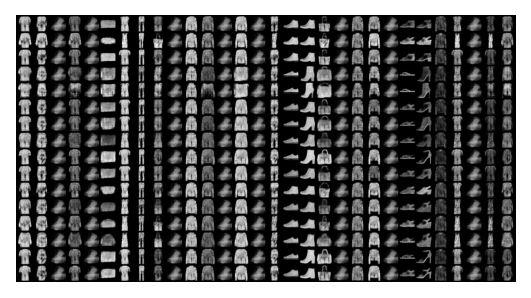

0.6993


<Figure size 320x320 with 0 Axes>

In [10]:
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

In [22]:
output = model(test_data, )
adata.obsm["z"] = output["mu_z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output

In [23]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata,)
sc.tl.louvain(adata,)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


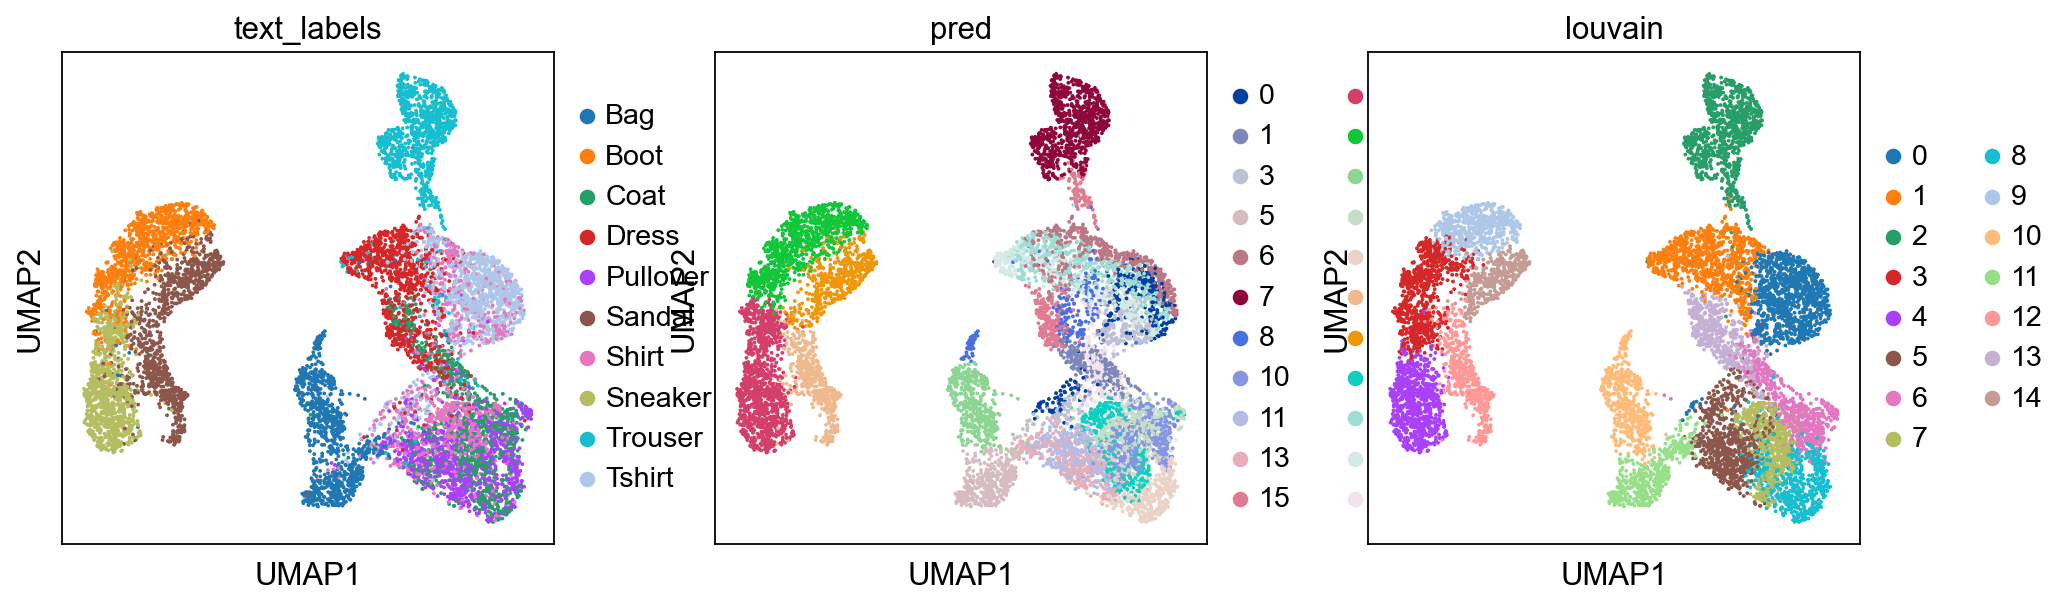

In [24]:
sc.pl.umap(
    adata,
    color=[
        "text_labels",
        "pred",
        "louvain",
    ],
)

### Old Model Reload

In [26]:
temp = ut.loadModelParameter("results/1660563478.092586model_params.pt")
temp

{'myName': "<class 'gmmvae16.VAE_Dirichlet_GMM_Type1602z'>",
 'training': False,
 '_buffers': {},
 '_backward_hooks': {},
 '_is_full_backward_hook': None,
 '_forward_hooks': {},
 '_forward_pre_hooks': {},
 '_state_dict_hooks': {},
 '_load_state_dict_pre_hooks': {},
 'nx': 784,
 'nh': 1024,
 'nhq': 1024,
 'nhp': 1024,
 'nz': 8,
 'nw': 8,
 'eps': 1e-09,
 'nclasses': 20,
 'numhidden': 2,
 'numhiddenq': 2,
 'numhiddenp': 2,
 'dscale': 1.0,
 'wscale': 1.0,
 'yscale': 1.0,
 'zscale': 1.0,
 'cc_scale': 10.0,
 'cc_radius': 0.1,
 'mi_scale': 1.0,
 'recloss_mii': 0,
 'concentration': 1.0,
 'relax': True,
 'restrict_w': True,
 'restrict_z': True,
 'do_cc': False,
 'softargmax': False,
 'use_resnet': False,
 'reclosstype': 'Bernoulli'}

In [27]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602z(
    nx=28**2,
    nclasses=20,
    nh=1024,
    nhq=1024,
    nhp=1024,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=2e-2,
    bn=True,
    reclosstype="Bernoulli",
    #reclosstype="mse",
    #relax=False,
    relax=True,
    restrict_w=True,
    restrict_z=True,
    nz=8,
    nw=8,
)
model.load_state_dict(
    torch.load(
        "results/1660563478.171099model_state.pt")
)

<All keys matched successfully>

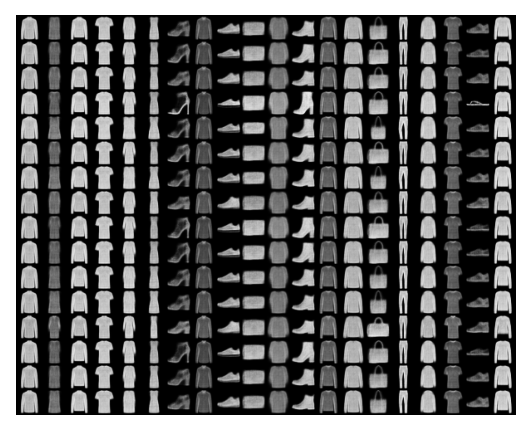

0.7519


<Figure size 320x320 with 0 Axes>

In [28]:
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())


In [29]:
output = model(test_data, )
adata.obsm["z"] = output["mu_z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output

In [30]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata,)
sc.tl.louvain(adata,)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


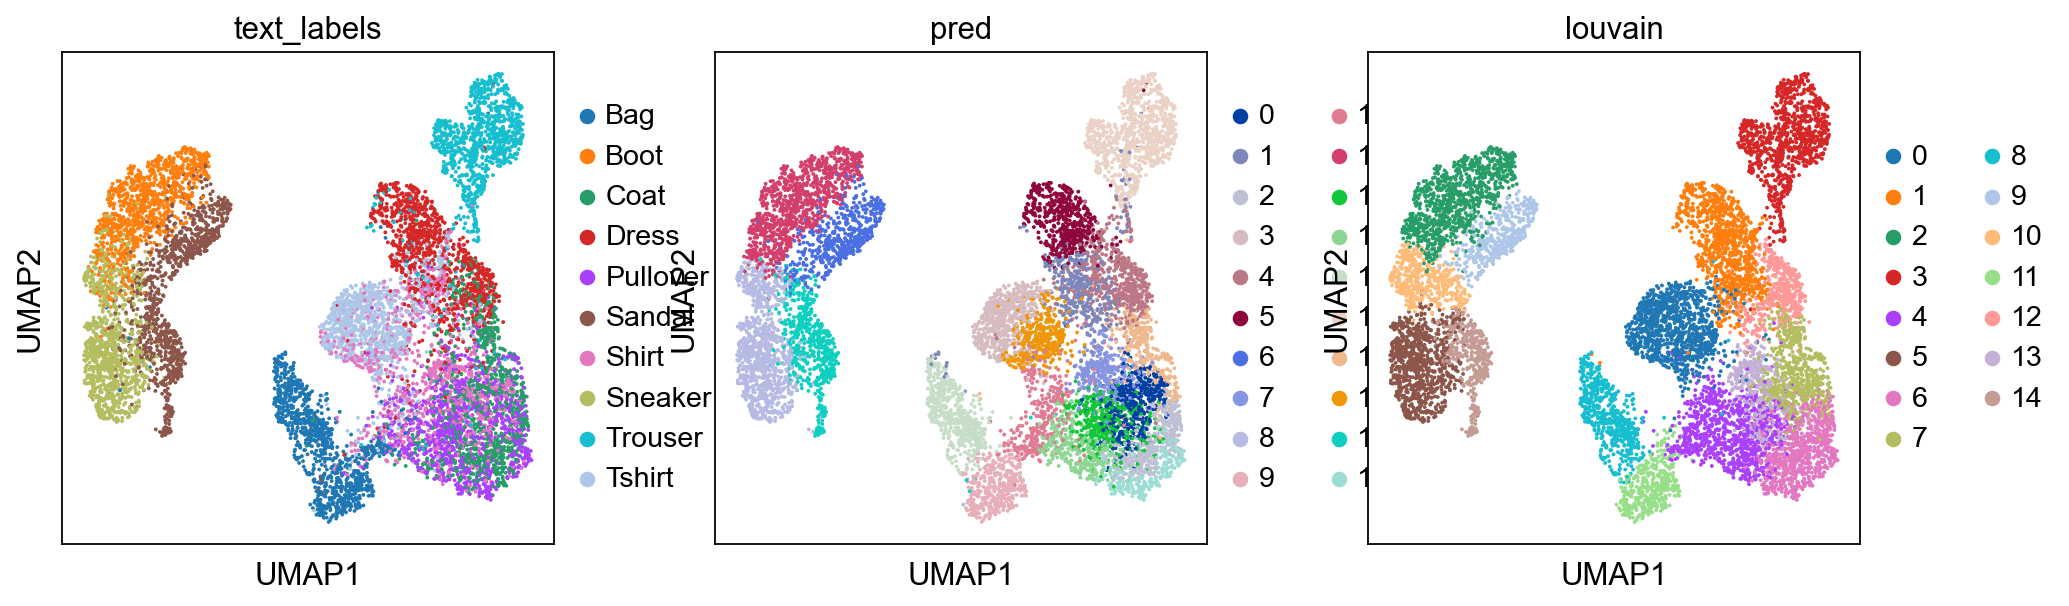

In [31]:
sc.pl.umap(
    adata,
    color=[
        "text_labels",
        "pred",
        "louvain",
    ],
)

In [97]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602z(
    nx=28**2,
    nclasses=20,
    concentration=1e1,
    nh=1024,
    nhq=1024,
    nhp=1024,
    numhidden=1,
    numhiddenp=1,
    numhiddenq=1,
    dropout=0e-1,
    #bn=True,
    bn=False,
    reclosstype="Bernoulli",
    #reclosstype="mse",
    #relax=False,
    relax=True,
    restrict_w=True,
    restrict_z=True,
    nz=8,
    nw=8,
)
model.apply(init_weights)
model.__class__

gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602z

epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
done training


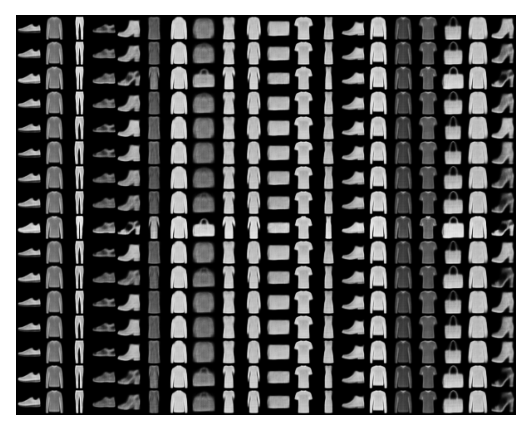

0.6602


<Figure size 320x320 with 0 Axes>

In [98]:
Train.basicTrainLoop(
    model,
    data_loader,
    test_loader,
    num_epochs=10,
    #lrs=[1e-3,5e-4,1e-4,5e-5,1e-5],
    lrs = [
        #1e-2,
        1e-3,
        #1e-3,
        1e-4,
        #1e-4,
        1e-5,
        #1e-5,
        #1e-6,
        #1e-3,
    ],
    #wt=1e-3,
    wt=1e-4,
    #wt=1e-7,
    report_interval=0,
    #do_plot=True,
    #test_accuracy=True,
)
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
model.eval()
print((r*s).sum() / s.sum())

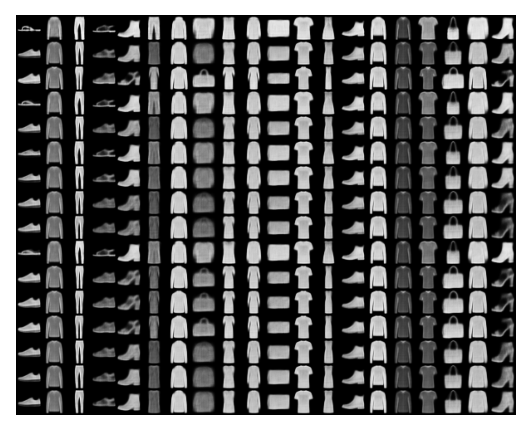

[0.85013624 0.43177189 1.         0.77132486 0.65018315 0.42926829
 0.5        0.55240793 0.525      0.47674419 0.96941896 0.84707904
 0.88780488 0.58805031 0.46639511 0.36951501 0.65706806 0.99065421
 0.42795699 0.51391466]
[734. 491. 848. 551. 546. 410. 584. 353. 360. 430. 327. 582. 410. 636.
 491. 433. 382. 428. 465. 539.]
0.6609


<Figure size 320x320 with 0 Axes>

In [99]:
model.eval()
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(r)
print(s)
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  0.0001
epoch's lr =  1e-05
epoch's lr =  1e-05
epoch's lr =  1e-06
epoch's lr =  1e-06
done training


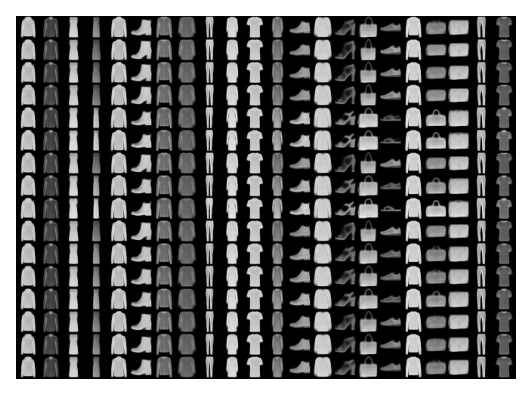

0.677


<Figure size 320x320 with 0 Axes>

In [39]:
Train.basicTrainLoop(
    model,
    data_loader,
    test_loader,
    num_epochs=15,
    #lrs=[1e-3,5e-4,1e-4,5e-5,1e-5],
    lrs = [
        #1e-2,
        1e-3,
        1e-3,
        1e-4,
        1e-4,
        1e-5,
        1e-5,
        1e-6,
        1e-6,
    ],
    wt=1e-7,
    report_interval=0,
    #do_plot=True,
    #test_accuracy=True,
)
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


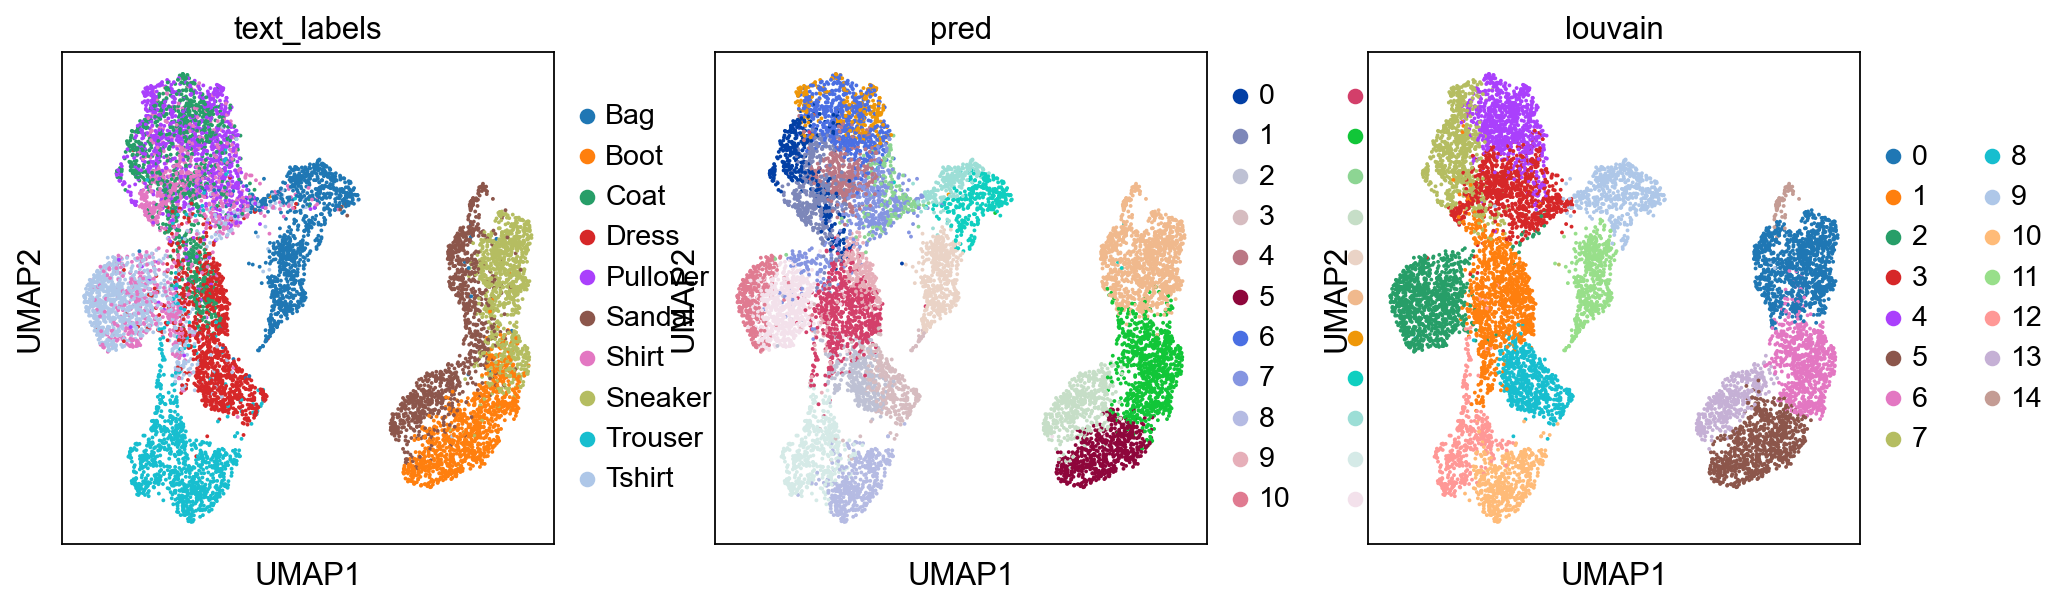

In [40]:
output = model(test_data, )
adata.obsm["z"] = output["mu_z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata,)
sc.tl.louvain(adata,)
sc.pl.umap(
    adata,
    color=[
        "text_labels",
        "pred",
        "louvain",
    ],
)

## FashionMNIST Semisupervised

In [131]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602z(
    nx=28**2,
    nclasses=10,
    concentration=1e-0,
    nh=1024,
    nhq=1024,
    nhp=1024,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0e-1,
    bn=True,
    yscale=1e0,
    zscale=1e0,
    wscale=1e0,
    reclosstype="Bernoulli",
    #reclosstype="mse",
    relax=False,
    #relax=True,
    restrict_w=True,
    restrict_z=True,
    nz=32,
    nw=32,
)
model.apply(init_weights)
model.__class__

gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602z

In [110]:
temp = ut.loadModelParameter(
    "./results/1660567792.04402ss_fmnist__model_params.pt",
)
temp

{'myName': "<class 'gmmvae16.VAE_Dirichlet_GMM_Type1602z'>",
 'training': False,
 '_buffers': {},
 '_backward_hooks': {},
 '_is_full_backward_hook': None,
 '_forward_hooks': {},
 '_forward_pre_hooks': {},
 '_state_dict_hooks': {},
 '_load_state_dict_pre_hooks': {},
 'nx': 784,
 'nh': 1024,
 'nhq': 1024,
 'nhp': 1024,
 'nz': 32,
 'nw': 32,
 'eps': 1e-09,
 'nclasses': 10,
 'numhidden': 2,
 'numhiddenq': 2,
 'numhiddenp': 2,
 'dscale': 1.0,
 'wscale': 1.0,
 'yscale': 1.0,
 'zscale': 1.0,
 'cc_scale': 10.0,
 'cc_radius': 0.1,
 'mi_scale': 1.0,
 'recloss_mii': 0,
 'concentration': 1.0,
 'relax': False,
 'restrict_w': True,
 'restrict_z': True,
 'do_cc': False,
 'softargmax': False,
 'use_resnet': False,
 'reclosstype': 'Bernoulli'}

In [111]:
model.load_state_dict(
    torch.load(
        "./results/1660567792.12484ss_fmnist_model_state.pt",
    ),
)

<All keys matched successfully>

In [104]:
#reload(Train)
Train.trainSemiSuperLoop(
        model,
        labeled_data_loader,
        unlabeled_data_loader,
        test_loader,
        num_epochs=10,
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,1e-5,1e-6,],
        lrs = [
            1e-3,
        ],
        wt=0e-3,
        do_unlabeled=True,
        #do_plot=True,
        #do_validation=True,
        #test_accuracy=True,
        report_interval=0,
        )

True
epoch's lr =  0.001
done training


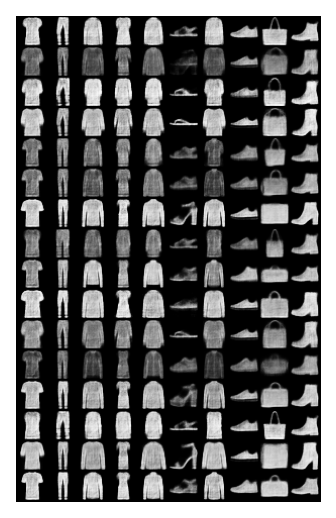

[0.78055823 0.99582463 0.71321462 0.86196624 0.73396226 0.97416577
 0.64046243 0.89770554 0.96092184 0.91949564]
[1039.  958. 1067. 1007. 1060.  929.  865. 1046.  998. 1031.]
0.8477


<Figure size 320x320 with 0 Axes>

In [112]:
model.eval()
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(r)
print(s)
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


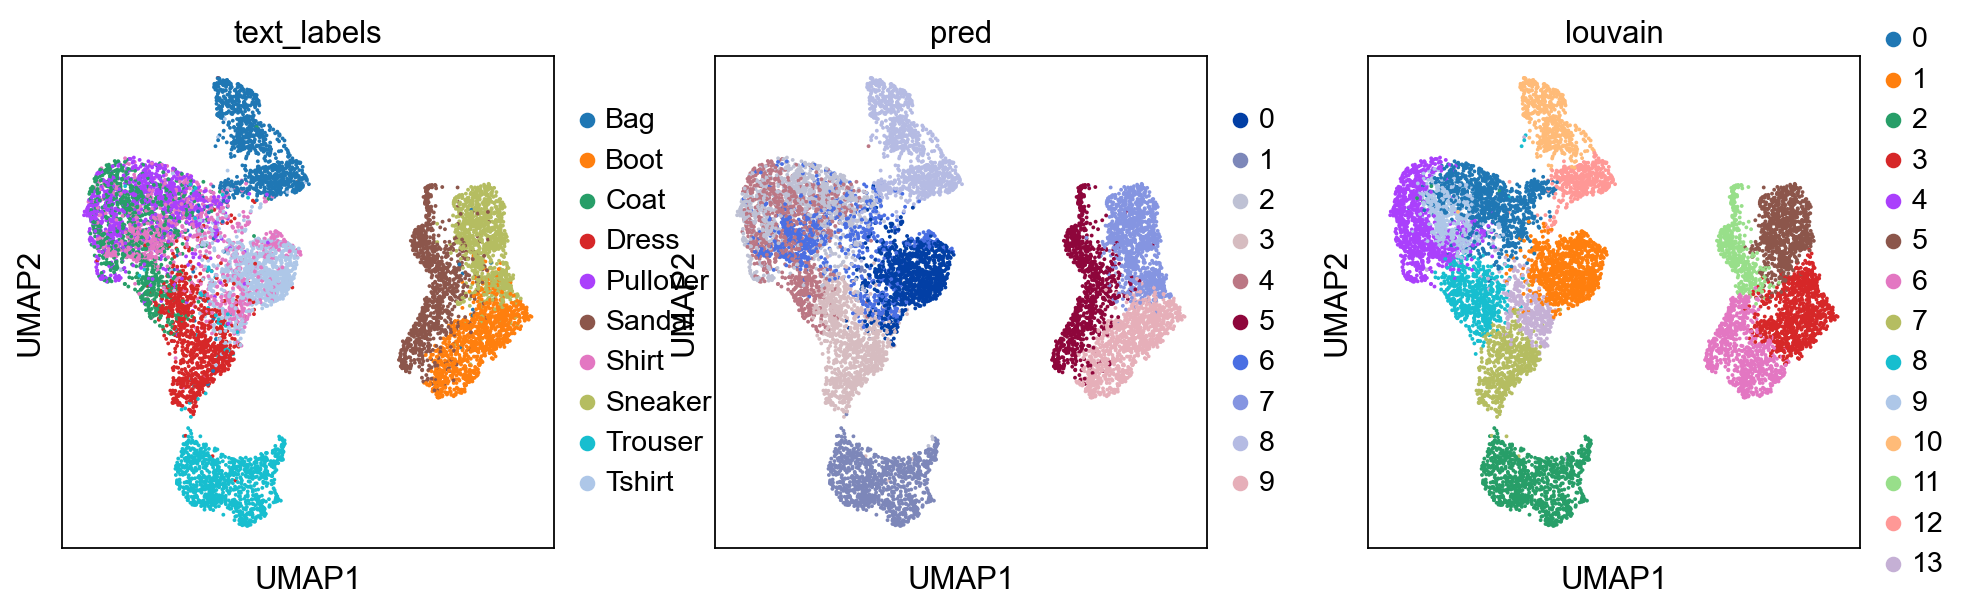

In [113]:
output = model(test_data, )
adata.obsm["z"] = output["mu_z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata,)
sc.tl.louvain(adata,)
sc.pl.umap(
    adata,
    color=[
        "text_labels",
        "pred",
        "louvain",
    ],
)

In [120]:
model.apply(init_weights)
print()

In [137]:
#reload(Train)
Train.trainSemiSuperLoop(
        model,
        labeled_data_loader,
        unlabeled_data_loader,
        test_loader,
        num_epochs=50,
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,1e-5,1e-6,],
        lrs = [
            1e-3,
            1e-3,
            1e-4,
            1e-5,
        ],
        wt=0,
        do_unlabeled=True,
        #do_plot=True,
        #do_validation=True,
        #test_accuracy=True,
        #report_interval=10,
        report_interval=0,
)

epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
done training


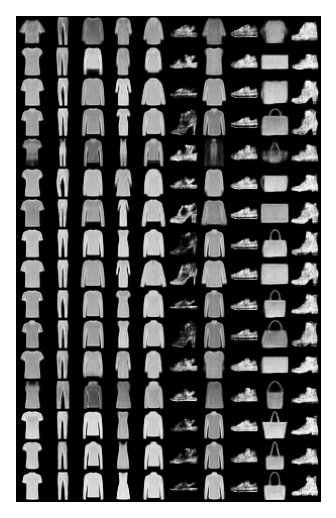

[0.73133047 1.         0.73407482 0.82369146 0.72350674 0.97858672
 0.58970976 0.90547264 0.97108674 0.89971884]
[1165.  952.  989. 1089. 1038.  934.  758. 1005. 1003. 1067.]
0.8383


<Figure size 320x320 with 0 Axes>

In [138]:
model.eval()
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(r)
print(s)
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


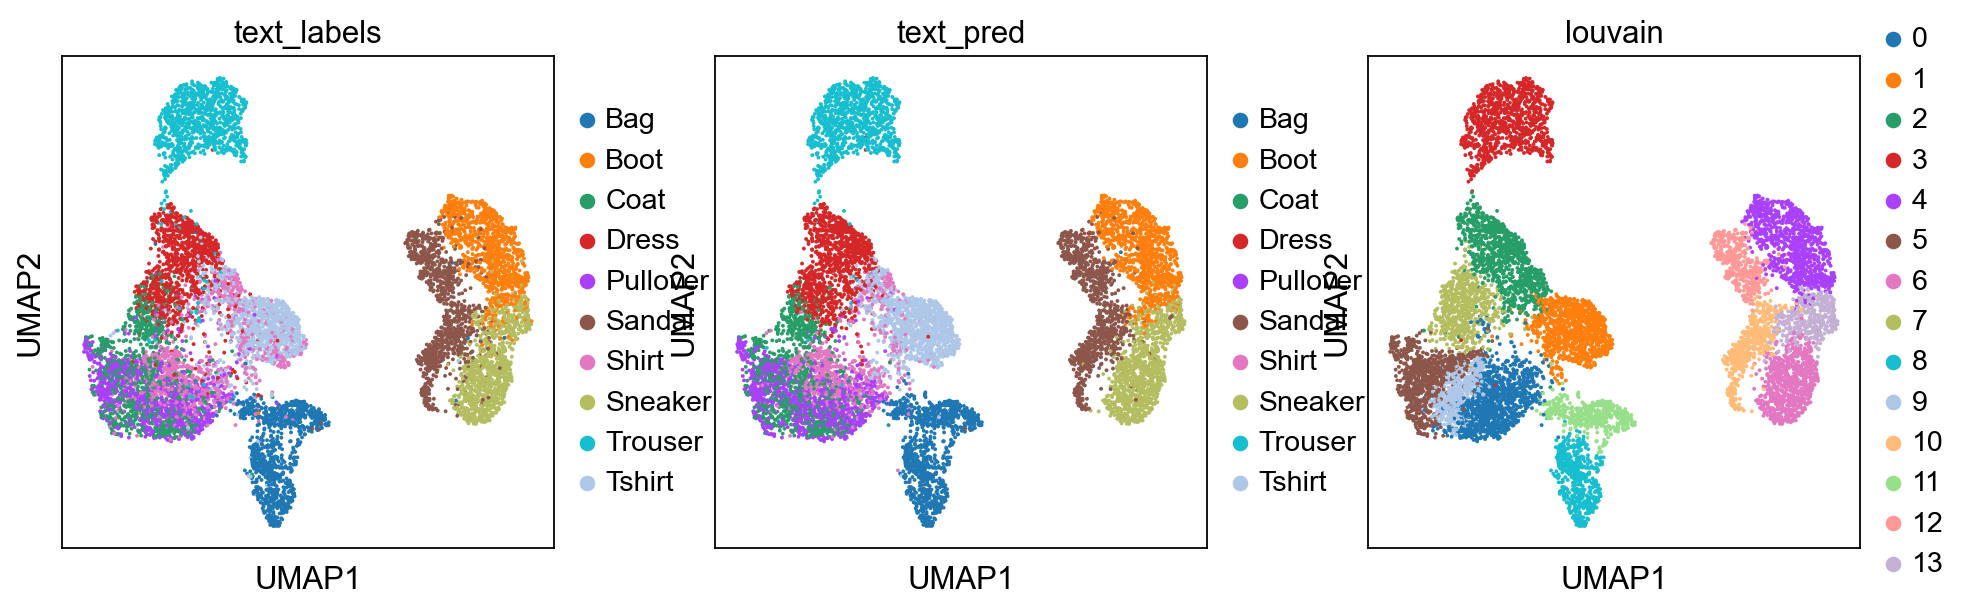

In [136]:
output = model(test_data, )
adata.obsm["z"] = output["mu_z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
pnames = list(output["q_y"].detach().argmax(-1).numpy())
pnames = [d[i] for i in pnames]
#pnames
adata.obs['text_pred'] = pnames
#adata.obs
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata,)
sc.tl.louvain(adata,)
sc.pl.umap(
    adata,
    color=[
        "text_labels",
        "text_pred",
        "louvain",
    ],
)
del output

In [140]:
#reload(Train)
Train.trainSemiSuperLoop(
        model,
        data_loader,
        data_loader,
        #labeled_data_loader,
        #unlabeled_data_loader,
        test_loader,
        num_epochs=50,
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,1e-5,1e-6,],
        lrs = [
            1e-3,
            1e-3,
            1e-4,
            1e-5,
        ],
        wt=0,
        #do_unlabeled=True,
        do_unlabeled=False,
        #do_plot=True,
        #do_validation=True,
        #test_accuracy=True,
        #report_interval=10,
        report_interval=0,
)

epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
done training


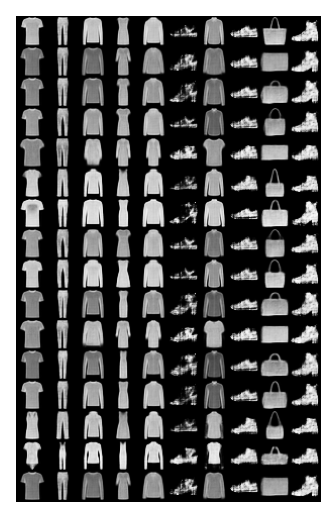

[0.83165323 0.99292214 0.79759519 0.89959839 0.79494655 0.97971602
 0.6959596  0.93542074 0.98103792 0.95883534]
[ 992.  989.  998.  996. 1029.  986.  990. 1022. 1002.  996.]
0.8866


<Figure size 320x320 with 0 Axes>

In [141]:
model.eval()
ut.do_plot_helper(model, "cpu")
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(r)
print(s)
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())
